# Predicting Diatom concentration with functional regression (spatial means)

## Importing

In [209]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xskillscore as xs

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import r_regression

from skfda.representation.grid import FDataGrid
from skfda.ml.regression import HistoricalLinearRegression, KernelRegression

from skfda.misc.hat_matrix import NadarayaWatsonHatMatrix, LocalLinearRegressionHatMatrix, KNeighborsHatMatrix
from skfda.preprocessing.smoothing import KernelSmoother

from sklearn.metrics import root_mean_squared_error as rmse

import os
import lzma
import dill

import random

import cmocean.cm as cm
import salishsea_tools.viz_tools as sa_vi

np.warnings.filterwarnings('ignore') # For the nan mean warning


## Datasets Preparation

In [210]:
# Creation of the training - testing datasets
def datasets_preparation(dataset, dataset2, name):
    
    indx = np.where((dataset.time_counter.dt.month==2) & (dataset.time_counter.dt.day==29))
    
    targets = dataset[name].to_numpy().reshape(*dataset[name].to_numpy().shape[:1],-1)

    inputs = np.stack([
        dataset2['Summation_of_solar_radiation'].to_numpy().reshape(*dataset2['Summation_of_solar_radiation'].to_numpy().shape[:1],-1),
        dataset2['Mean_air_temperature'].to_numpy().reshape(*dataset2['Mean_air_temperature'].to_numpy().shape[:1],-1),
        dataset2['Mean_pressure'].to_numpy().reshape(*dataset2['Mean_pressure'].to_numpy().shape[:1],-1),
        dataset2['Mean_precipitation'].to_numpy().reshape(*dataset2['Mean_precipitation'].to_numpy().shape[:1],-1),
        dataset2['Mean_specific_humidity'].to_numpy().reshape(*dataset2['Mean_specific_humidity'].to_numpy().shape[:1],-1),
        ])

    # Deleting 29 of February
    inputs = np.delete(inputs,indx,axis=1)
    targets = np.delete(targets,indx,axis=0)

    inputs = np.nanmean(inputs,axis=2)
    targets = np.nanmean(targets,axis=1)

    inputs = np.reshape(inputs,(len(inputs),inputs.shape[1]//len(np.unique(dataset.time_counter.dt.year)),len(np.unique(dataset.time_counter.dt.year))), order = 'F')
    targets = np.reshape(targets,(len(targets)//len(np.unique(dataset.time_counter.dt.year)),len(np.unique(dataset.time_counter.dt.year))), order = 'F')

    return(inputs, targets, indx)


## File Creation

In [211]:
def file_creation(path, variable, name):

    temp = variable.to_dataset(name=name)
    temp.to_netcdf(path = path + 'targets_predictions.nc', mode='a', encoding={name:{"zlib": True, "complevel": 9}})
    

## Regressor

In [212]:
def regressor (inputs, targets, name):

    # Printing of the correlation coefficients
    temp_inputs = np.reshape(inputs,(len(inputs),inputs.shape[1]*inputs.shape[2]))
    temp_inputs = temp_inputs.transpose()
    temp_targets = np.ravel(targets)

    # r = np.round(r_regression(temp_inputs,temp_targets),2)
    # dict = {'Summation_of_solar_radiation':r[0], 'Mean_wind_speed':r[1], 'Mean_air_temperature':r[2]}

    # print('The correlation coefficients between each input and ' + name +  ' are: ' +str(dict))

    # Scaling the inputs
    scaler_inputs = make_column_transformer((StandardScaler(), [0,1,2,3,4]))
    temp_inputs = scaler_inputs.fit_transform(temp_inputs)
    temp_inputs = temp_inputs.transpose()
    inputs = np.reshape(temp_inputs,(len(inputs),inputs.shape[1],inputs.shape[2]))   
    inputs = np.transpose(inputs,axes=(2,1,0))
    
    # Scaling the targets
    scaler_targets = StandardScaler()
    temp_targets = np.expand_dims(temp_targets,-1)
    temp_targets = scaler_targets.fit_transform(temp_targets)
    targets = temp_targets.reshape(targets.shape)

    # Final transformations
    targets = targets.transpose()
    inputs = FDataGrid(data_matrix=inputs, grid_points=np.arange(0,len(targets[0])))
    targets = FDataGrid(data_matrix=targets, grid_points=np.arange(0,len(targets[0])))

    # # Smoothing
    # # targets = targets.to_basis(FourierBasis(n_basis=10))
    kernel_estimator = LocalLinearRegressionHatMatrix(bandwidth=1)
    smoother = KernelSmoother(kernel_estimator=kernel_estimator)
    inputs = smoother.fit_transform(inputs)

    model = HistoricalLinearRegression(n_intervals=3,lag=50)
    regr = model.fit(inputs,targets)

    return(regr,scaler_inputs,scaler_targets,smoother)


## Scaling

In [213]:
def scaling(regr,inputs,scaler_inputs,targets,scaler_targets,smoother):

    # targets = targets.to_basis(FourierBasis(n_basis=10)

    # # Scaling the inputs
    temp = np.reshape(inputs,(len(inputs),inputs.shape[1]*inputs.shape[2]))
    temp = temp.transpose()
    temp = scaler_inputs.transform(temp)
    temp = temp.transpose()        
    inputs = np.reshape(temp,(len(inputs),inputs.shape[1],inputs.shape[2]))
        
    inputs = np.transpose(inputs,axes=(2,1,0))
    inputs = FDataGrid(data_matrix=inputs, grid_points=np.arange(0,len(targets)))

    inputs = smoother.transform(inputs)

    predictions = regr.predict(inputs)

    # Post-processing of predictions
    predictions = np.array(predictions.to_grid(np.arange(0,len(targets))).data_matrix)
    predictions = np.squeeze(predictions,2)

    # # Scaling the predictions
    temp = np.ravel(predictions)
    temp = np.expand_dims(temp,axis=-1)
    temp = scaler_targets.inverse_transform(temp)
    predictions = temp.reshape(predictions.shape)
    predictions = predictions.transpose()

    return(predictions)


## Scatter Plot

In [214]:
def scatter_plot(dates, targets, predictions, name):

    indx = pd.DatetimeIndex(dates[0:75]) # From the first year

    # compute slope m and intercept b
    m, b = np.polyfit(targets, predictions, deg=1)

    fig, ax = plt.subplots()

    scatter = ax.scatter(targets,predictions, s = 10, c= indx.month)

    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()])]

    # plot fitted y = m*x + b
    ax.axline(xy1=(0, b), slope=m, color='r')

    ax.set_xlabel('targets')
    ax.set_ylabel('predictions')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect('equal')
    ax.legend(handles=scatter.legend_elements()[0], labels=['February','March','April'])

    ax.plot(lims, lims,linestyle = '--',color = 'k')

    fig.suptitle(name)

    plt.show()

    return(m)


## Plotting (Mean Values)

In [215]:
def plotting_mean_values(dates,mean_targets,mean_predictions,category,units,region):

    years = np.unique(dates.year)
    ticks = [0]
    
    fig, _ = plt.subplots(figsize=(19,5))
    
    mean_targets = np.ma.array(mean_targets)
    mean_predictions = np.ma.array(mean_predictions)

    for year in years[:-1]:
        ticks.append((np.where(dates.year==year)[0][-1]+1))
        mean_targets[(np.where(dates.year==year)[0][-1]+1)] = np.ma.masked
        mean_predictions[(np.where(dates.year==year)[0][-1]+1)] = np.ma.masked

    plt.plot(mean_targets, label = 'targets')
    plt.plot(mean_predictions, label = 'predictions')
    plt.xlabel('Years')
    plt.xticks(ticks,years)
    plt.suptitle('Mean '+category + ' ' +units + ' (15 Feb - 30 Apr) ' + region)
    plt.legend()
    
    fig.show()


## Evaluation

In [216]:
def evaluation(id,dates,years,targets,predictions,name):

    # For every year
    r_years = np.array([])
    rms_years = np.array([])
    slope_years = np.array([])

    for i in range (0,len(years)):

        r_year = np.round(np.corrcoef(np.ravel(targets[:,i]), np.ravel(predictions[:,i]))[0][1],3)
        rms_year = np.round(rmse(np.ravel(targets[:,i]), np.ravel(predictions[:,i])),5)
        m,_ = np.polyfit(np.ravel(targets[:,i]), np.ravel(predictions[:,i]), deg=1)
        slope_year = np.round(m,3)

        r_years = np.append(r_years,r_year)
        rms_years = np.append(rms_years,rms_year)
        slope_years = np.append(slope_years,slope_year)

        if id == 0:
            _ = scatter_plot(dates, targets[:,i], predictions[:,i], name + ' for '+ str(years[i])) 

    return r_years,rms_years,slope_years


## Training

The correlation coefficient during training is: 0.951
The rmse during training is: 0.005109911883693952
The slope of the best fitting line during training is: 0.904


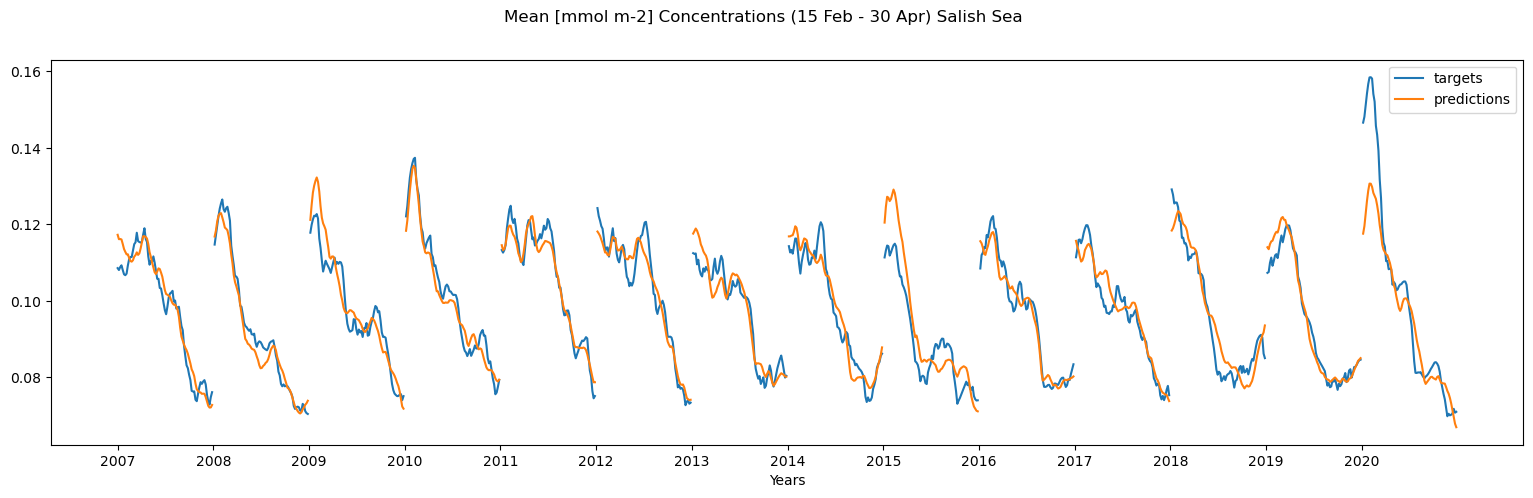

In [217]:
name = 'Flagellate'
units = '[mmol m-2]'
category = 'Concentrations'

ds = xr.open_dataset('/data/ibougoudis/MOAD/files/integrated_original.nc')
ds2 = xr.open_dataset('/data/ibougoudis/MOAD/files/external_inputs.nc')

# ds = ds.isel(y=(np.arange(ds.y[0], ds.y[-1], 5)), 
#     x=(np.arange(ds.x[0], ds.x[-1], 5)))

# ds2 = ds2.isel(y=(np.arange(ds2.y[0], ds2.y[-1], 5)), 
#     x=(np.arange(ds2.x[0], ds2.x[-1], 5)))

dataset = ds.sel(time_counter = slice('2007', '2020'))
dataset2 = ds2.sel(time_counter = slice('2007', '2020'))

inputs, targets, indx = datasets_preparation(dataset, dataset2, name)

regr,scaler_inputs,scaler_targets,smoother = regressor(inputs, targets, name)

predictions = scaling(regr,inputs,scaler_inputs,targets,scaler_targets,smoother)

r_train = np.round(np.corrcoef(np.ravel(targets),np.ravel(predictions))[0][1],3)
rms_train = rmse(np.ravel(targets),np.ravel(predictions))
m,_ = np.polyfit(np.ravel(targets), np.ravel(predictions), deg=1)
slope_train = np.round(m,3)

print ('The correlation coefficient during training is: ' + str(r_train))
print ('The rmse during training is: ' + str(rms_train))
print('The slope of the best fitting line during training is: '+str(slope_train))

dates = pd.DatetimeIndex(dataset['time_counter'].values)
indx2 = ~((dataset.time_counter.dt.month==2) & (dataset.time_counter.dt.day==29))
dates = dates[indx2]

plotting_mean_values(dates, np.reshape(targets,targets.shape[0]*targets.shape[1],order='F'), np.reshape(predictions,predictions.shape[0]*predictions.shape[1],order='F'), units, category, 'Salish Sea')


In [218]:
test = regr.coef_
coeff = test.data_matrix
coeff = np.where(coeff==0,np.nan,coeff)

Text(0, 0.5, 'Day')

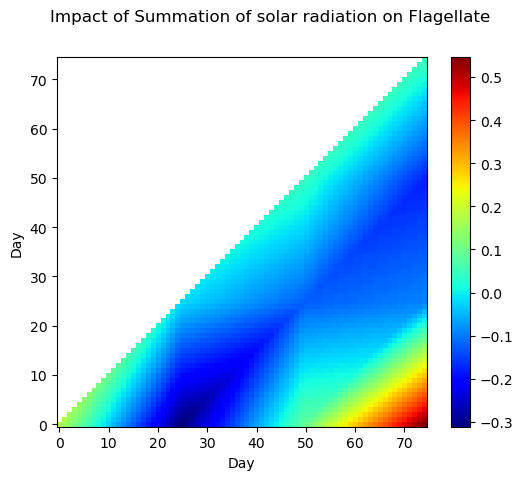

In [219]:
plt.imshow(coeff[0,:,:,0],cmap='jet')
plt.gca().invert_yaxis()
plt.colorbar()
plt.suptitle('Impact of Summation of solar radiation on Flagellate')
plt.xlabel('Day')
plt.ylabel('Day')


Text(0, 0.5, 'Day')

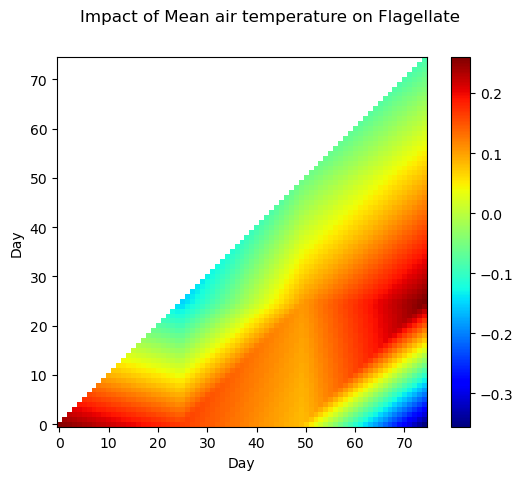

In [220]:
plt.imshow(coeff[0,:,:,1],cmap='jet')
plt.gca().invert_yaxis()
plt.colorbar()
plt.suptitle('Impact of Mean air temperature on Flagellate')
plt.xlabel('Day')
plt.ylabel('Day')

Text(0, 0.5, 'Day')

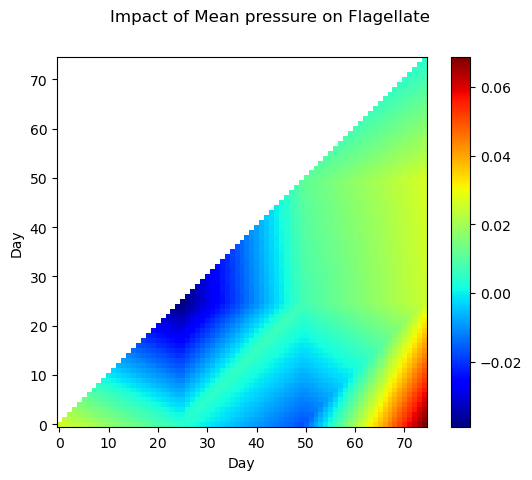

In [221]:
plt.imshow(coeff[0,:,:,2],cmap='jet')
plt.gca().invert_yaxis()
plt.colorbar()
plt.suptitle('Impact of Mean pressure on Flagellate')
plt.xlabel('Day')
plt.ylabel('Day')

Text(0, 0.5, 'Day')

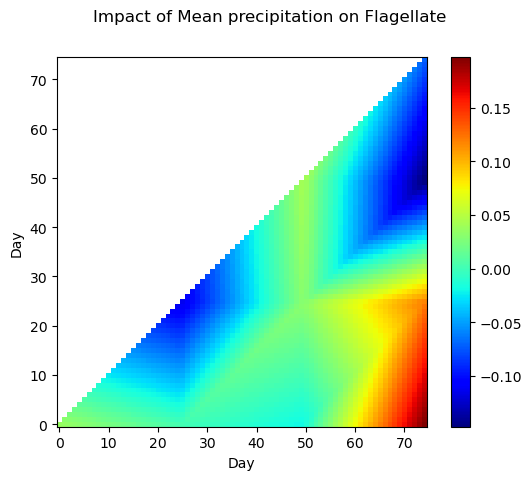

In [222]:
plt.imshow(coeff[0,:,:,3],cmap='jet')
plt.gca().invert_yaxis()
plt.colorbar()
plt.suptitle('Impact of Mean precipitation on Flagellate')
plt.xlabel('Day')
plt.ylabel('Day')

Text(0, 0.5, 'Day')

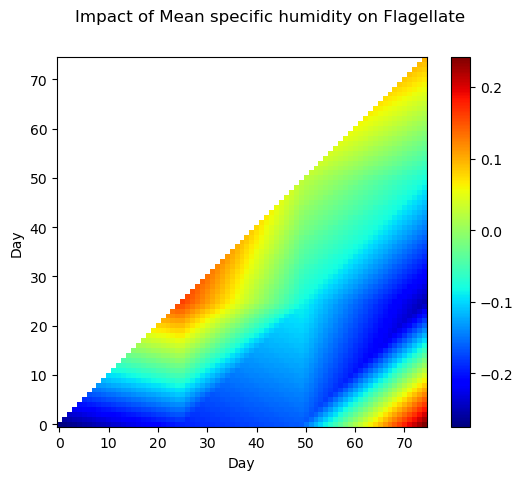

In [223]:
plt.imshow(coeff[0,:,:,4],cmap='jet')
plt.gca().invert_yaxis()
plt.colorbar()
plt.suptitle('Impact of Mean specific humidity on Flagellate')
plt.xlabel('Day')
plt.ylabel('Day')

## Seasonality

In [ ]:
season = np.mean(targets,axis=(1))
plt.plot(season)
plt.suptitle('Long-term seasonality (2007-2020)')

season_train = np.tile(season,targets.shape[1]) # Broadcasting season to all training years
season_train = np.reshape(season_train,(targets.shape[0],targets.shape[1]),order='F')

season_test = np.tile(season,len(np.unique(ds.sel(time_counter = slice('2021', '2024')).time_counter.dt.year))) # Broadcasting season to all testing years
season_test = np.reshape(season_test,(targets.shape[0],len(np.unique(ds.sel(time_counter = slice('2021', '2024')).time_counter.dt.year))),order='F')

quant_train = dataset[name] # Keeping it for the regional seasonalities
dates_season = pd.DatetimeIndex(quant_train['time_counter'].values)
    
plotting_mean_values(dates, np.reshape(targets-season_train,targets.shape[0]*targets.shape[1],order='F'), np.reshape(predictions-season_train,predictions.shape[0]*predictions.shape[1],order='F'), units, category, 'Salish Sea')


## Other Years

In [ ]:
dataset = ds.sel(time_counter = slice('2021', '2024'))
dataset2 = ds2.sel(time_counter = slice('2021', '2024'))

dates = pd.DatetimeIndex(dataset['time_counter'].values)
years = np.unique(dataset.time_counter.dt.year)

indx = ~((dataset.time_counter.dt.month==2) & (dataset.time_counter.dt.day==29))
dates = dates[indx]

inputs, targets, indx = datasets_preparation(dataset, dataset2, name)

predictions = scaling(regr,inputs,scaler_inputs,targets,scaler_targets,smoother)

r_test = np.round(np.corrcoef(np.ravel(targets),np.ravel(predictions))[0][1],3)
rms_test = rmse(np.ravel(targets),np.ravel(predictions))
m,_ = np.polyfit(np.ravel(targets), np.ravel(predictions), deg=1)
slope_test = np.round(m,3)

print ('The correlation coefficient during testing is: ' + str(r_test))
print ('The rmse during testing is: ' + str(rms_test))
print ('The slope of the best fitting line during testing is: ' + str(slope_test))

r_test,rms_test,slope_test = evaluation(0,dates,years,targets,predictions,name)
plotting_mean_values(dates, np.reshape(targets,targets.shape[0]*targets.shape[1],order='F'), np.reshape(predictions,predictions.shape[0]*predictions.shape[1],order='F'), units, category, 'Salish Sea')

r_test_season,rms_test_season,slope_test_season = evaluation(1,dates,years,targets-season_test,predictions-season_test,name)
plotting_mean_values(dates, np.reshape(targets-season_test,targets.shape[0]*targets.shape[1],order='F'), np.reshape(predictions-season_test,predictions.shape[0]*predictions.shape[1],order='F'), units, category, 'Salish Sea (removed seasonality)')


## Saving

In [194]:
# path = '/data/ibougoudis/MOAD/files/results/' + name + '/func_reg_s/'

# os.makedirs(path, exist_ok=True)
# with lzma.open(path + 'regr_all.xz', 'wb') as f:
    
#     dill.dump(regr, f)

# with open(path + 'metrics.pkl', 'wb') as f:
#     dill.dump([r_train,rms_train,slope_train,r_test,rms_test,slope_test,r_test_season,rms_test_season,slope_test_season], f)
